In [ ]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.interpolate import interp1d
from scipy.spatial import distance
from tqdm import tqdm

In [3]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

In [5]:
# 바운딩 박스 비율 클래스 정의 함수
def bbox_ratio_class(ratio):
    if ratio < 0.7:
        return 0  # Normal 가능성 높은 class
    else:
        return 1  # Danger or Fall 가능성 높은 class

# YOLO xy 비율 계산 함수
def calculate_yolo_xy_ratio(frame):
    bbox = frame.get('bbox', None)
    if bbox and (bbox['x2'] - bbox['x1']) != 0:
        yolo_xy_ratio = round((bbox['y2'] - bbox['y1']) / (bbox['x2'] - bbox['x1']), 3)
    else:
        yolo_xy_ratio = 0.0
    return yolo_xy_ratio

In [6]:
# 머리 및 상체 속도 계산 함수 (시퀀스 평균값 사용)
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints.get(f'landmark_0', {}).get('x', 0.0), keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        l = np.array([keypoints.get(f'landmark_11', {}).get('x', 0.0), keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        r = np.array([keypoints.get(f'landmark_12', {}).get('x', 0.0), keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 이전 프레임의 좌표
        prev_h = np.array([prev_keypoints.get(f'landmark_0', {}).get('x', 0.0), prev_keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        prev_l = np.array([prev_keypoints.get(f'landmark_11', {}).get('x', 0.0), prev_keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        prev_r = np.array([prev_keypoints.get(f'landmark_12', {}).get('x', 0.0), prev_keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 현재 프레임과 이전 프레임의 상체 중심
        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        # 유클리드 거리 계산 (6프레임당 일정하므로 속력이라 봐도 무방함)
        dist_new = distance.euclidean(center_new, center_prev)
        speeds.append(dist_new)

    # 평균 속력 계산
    if speeds:
        return sum(speeds) / len(speeds)
    else:
        return 0.0

In [7]:
# 데이터셋 클래스 정의
# 현재 input은 mediapipe의 관절 좌표값 22개 + YOLO xy ratio + bbox_ratio_class + 머리/상체 속도 => 25개
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3, input_config='full'):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        # self.scaler = StandardScaler()
        self.input_config = input_config

        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            with open(json_file, 'r') as f:
                data = json.load(f)

            frames = list(data['pose_data'].values())

            for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                sequence = frames[i:i + self.sequence_length]
                landmarks = []

                # YOLO xy ratio 및 바운딩 박스 클래스는 시퀀스마다 1개씩만 추가
                yolo_xy_ratio = calculate_yolo_xy_ratio(sequence[-1])  # 마지막 프레임 기준으로 계산
                ratio_class = bbox_ratio_class(yolo_xy_ratio)
                head_torso_speed = calculate_head_upper_body_speed(sequence)

                for j, frame in enumerate(sequence):
                    frame_landmarks = []
                    if frame is not None:
                        if self.input_config in ['full', 'mediapipe']:
                            for landmark in LANDMARKS:
                                landmark_data = frame.get(f'landmark_{landmark}', None)
                                if landmark_data:
                                    frame_landmarks.extend([
                                        round(landmark_data['x'], 3),  # 소수점 세 자리로 반올림
                                        round(landmark_data['y'], 3)
                                    ])
                                else:
                                    frame_landmarks.extend([0.0, 0.0])

                        if self.input_config in ['full', 'simplified']:
                            # YOLO xy ratio, 바운딩 박스 클래스, 머리/상체 속도 추가 (시퀀스 단위로 동일 값 사용)
                            frame_landmarks.append(yolo_xy_ratio)
                            frame_landmarks.append(ratio_class)
                            frame_landmarks.append(head_torso_speed)
                    
                    landmarks.append(frame_landmarks)

                # 데이터 증강 없이 원래 데이터를 사용
                all_landmarks.extend(landmarks)

                # 레이블 재정의
                if sequence[-1]['class'] == 'Normal':
                    label = 0  # 비낙상
                elif sequence[-1]['class'] == 'Danger':
                    label = 1  # 낙상 위험
                elif sequence[-1]['class'] == 'Fall':
                    label = 2  # 완전 낙상

                self.sequences.append(landmarks)
                self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [8]:
# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

In [9]:
# 검증 및 테스트 데이터셋 로드 경로
train_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Train'
valid_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Val'
test_json_folder = r'D:\Falldown\Dataset\Video_Dataset\Json_combined\Test'

# 각 데이터 폴더에서 JSON 파일 목록 생성
train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
valid_json_files = [os.path.join(valid_json_folder, f) for f in os.listdir(valid_json_folder) if f.endswith('.json')]
test_json_files = [os.path.join(test_json_folder, f) for f in os.listdir(test_json_folder) if f.endswith('.json')]

# 데이터셋 생성 (입력 데이터 설정에 따라)
train_full_dataset = FallSequenceDataset(train_json_files, input_config='full')
valid_full_dataset = FallSequenceDataset(valid_json_files, input_config='full')
test_full_dataset = FallSequenceDataset(test_json_files, input_config='full')

train_simplified_dataset = FallSequenceDataset(train_json_files, input_config='simplified')
valid_simplified_dataset = FallSequenceDataset(valid_json_files, input_config='simplified')
test_simplified_dataset = FallSequenceDataset(test_json_files, input_config='simplified')

train_mediapipe_dataset = FallSequenceDataset(train_json_files, input_config='mediapipe')
valid_mediapipe_dataset = FallSequenceDataset(valid_json_files, input_config='mediapipe')
test_mediapipe_dataset = FallSequenceDataset(test_json_files, input_config='mediapipe')

# 데이터 로더 생성
train_loader_full = DataLoader(train_full_dataset, batch_size=32, shuffle=True)
valid_loader_full = DataLoader(valid_full_dataset, batch_size=32, shuffle=False)
test_loader_full = DataLoader(test_full_dataset, batch_size=32, shuffle=False)

train_loader_simplified = DataLoader(train_simplified_dataset, batch_size=32, shuffle=True)
valid_loader_simplified = DataLoader(valid_simplified_dataset, batch_size=32, shuffle=False)
test_loader_simplified = DataLoader(test_simplified_dataset, batch_size=32, shuffle=False)

train_loader_mediapipe = DataLoader(train_mediapipe_dataset, batch_size=32, shuffle=True)
valid_loader_mediapipe = DataLoader(valid_mediapipe_dataset, batch_size=32, shuffle=False)
test_loader_mediapipe = DataLoader(test_mediapipe_dataset, batch_size=32, shuffle=False)

Processing JSON files: 100%|██████████| 397/397 [00:01<00:00, 286.36it/s]


In [10]:
# 클래스 가중치 계산 및 손실 함수 정의 (훈련 데이터셋 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(train_full_dataset.labels), y=train_full_dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 준비
def create_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence[0])  # 시퀀스 내의 각 프레임에서 입력의 길이를 가져옴
        return FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 파라미터 설정
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

In [11]:
# 학습 루프
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_0001_full.pt', train_full_dataset, 0.0001),
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_001_full.pt', train_full_dataset, 0.001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_0001_simplified.pt', train_simplified_dataset, 0.0001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_001_simplified.pt', train_simplified_dataset, 0.001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_0001_mediapipe.pt', train_mediapipe_dataset, 0.0001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_001_mediapipe.pt', train_mediapipe_dataset, 0.001)
]:
    
    # 모델 파일이 이미 존재하는지 확인
    if os.path.exists(model_name):
        print(f"모델 '{model_name}' 이미 존재합니다. 학습을 건너뜁니다.", flush=True)
        continue  # 이미 존재하는 경우, 다음 루프 항목으로 넘어감

    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{train_loader.dataset.input_config}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

모델 'best_fall_detection_gru_0001_full.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_gru_001_full.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_gru_0001_simplified.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_gru_001_simplified.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_gru_0001_mediapipe.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_gru_001_mediapipe.pt' 이미 존재합니다. 학습을 건너뜁니다.


In [12]:
# 성능 지표 계산 함수 정의
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [20]:
# 학습, 검증, 테스트 데이터셋 평가
gru_results = []
for model_name, train_loader, val_loader, test_loader in [
    ('best_fall_detection_gru_001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_0001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_0001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe),
    ('best_fall_detection_gru_0001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe)
]:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_model_for_dataset(test_loader.dataset)
    model.load_state_dict(torch.load(model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': model_name}
    for loader_name, data_loader in [('Train', train_loader), ('Validation', val_loader), ('Test', test_loader)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    gru_results.append(scores)

best_fall_detection_gru_001_full.pt (Train): F1 Score: 0.9847
Confusion Matrix (Train):
[[35687   551   223]
 [    4  4858     6]
 [   45   156 21569]]
best_fall_detection_gru_001_full.pt (Validation): F1 Score: 0.9688
Confusion Matrix (Validation):
[[6627  134  119]
 [  32  972   13]
 [  55   42 4512]]
best_fall_detection_gru_001_full.pt (Test): F1 Score: 0.9704
Confusion Matrix (Test):
[[7600  133  131]
 [  37  890   15]
 [  33   38 4027]]
best_fall_detection_gru_0001_full.pt (Train): F1 Score: 0.8621
Confusion Matrix (Train):
[[30347  3343  2771]
 [  607  3884   377]
 [  989  1140 19641]]
best_fall_detection_gru_0001_full.pt (Validation): F1 Score: 0.8601
Confusion Matrix (Validation):
[[5699  620  561]
 [ 129  796   92]
 [ 209  227 4173]]
best_fall_detection_gru_0001_full.pt (Test): F1 Score: 0.8507
Confusion Matrix (Test):
[[6428  767  669]
 [ 110  763   69]
 [ 244  188 3666]]
best_fall_detection_gru_001_simplified.pt (Train): F1 Score: 0.7952
Confusion Matrix (Train):
[[27067  50

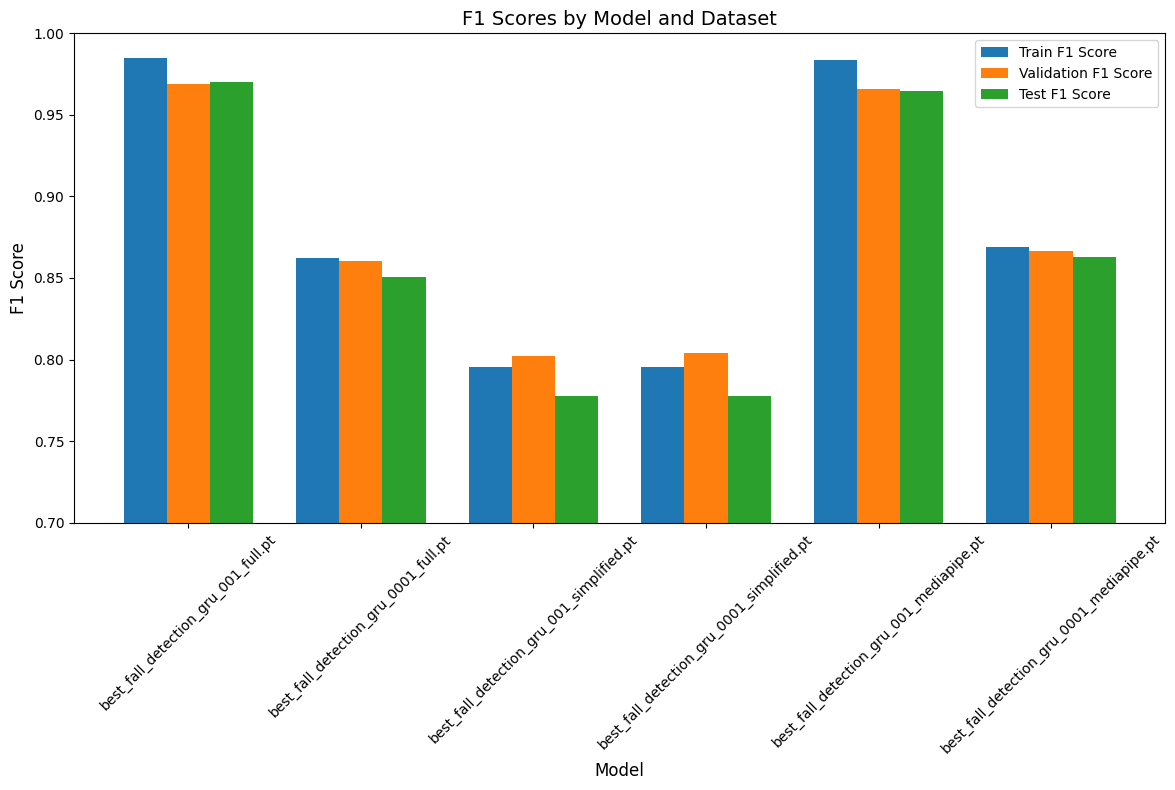

In [21]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in gru_results]
train_scores = [result['Train'] for result in gru_results]
val_scores = [result['Validation'] for result in gru_results]
test_scores = [result['Test'] for result in gru_results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [22]:
# CNN 기반 낙상 감지 모델 정의
class FallDetectionCNN(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(FallDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, padding=1)  # mediapipe dataset을 공유하므로 in_channels은 22
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.transpose(1, 2)  # Conv1d의 형태를 맞추기 위함 (batch_size, channels, length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # tensor flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
# 모델 준비
def create_cnn_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence)  # CNN에서는 시퀀스 길이를 input size로 사용
        return FallDetectionCNN(input_size=input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 및 검증 설정
cnn_model_configs = [
    ('best_fall_detection_cnn_mediapipe_001.pt', 0.001),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.0001)
]

# 학습 파라미터 설정
num_epochs = 500
patience = 20

In [24]:
# 두 가지 학습률로 CNN 학습 진행
for cnn_model_name, learning_rate in cnn_model_configs:

    # 모델 파일이 이미 존재하는지 확인
    if os.path.exists(cnn_model_name):
        print(f"모델 '{cnn_model_name}' 이미 존재합니다. 학습을 건너뜁니다.", flush=True)
        continue  # 이미 존재하는 경우, 다음 루프 항목으로 넘어감

    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0

    print(f"{cnn_model_name} 학습 시작 (lr={learning_rate})", flush=True)

    for epoch in range(num_epochs):
        model.train() # Training
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader_mediapipe, desc=f"Epoch {epoch + 1}/{num_epochs} (lr={learning_rate})"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss (lr={learning_rate}): {avg_loss_train:.4f}')

        model.eval() # Validation
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader_mediapipe:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss (lr={learning_rate}): {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), cnn_model_name)
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

모델 'best_fall_detection_cnn_mediapipe_001.pt' 이미 존재합니다. 학습을 건너뜁니다.
모델 'best_fall_detection_cnn_mediapipe_0001.pt' 이미 존재합니다. 학습을 건너뜁니다.


In [25]:
# 학습, 검증, 테스트 데이터셋 평가
cnn_results = []
for cnn_model_name, _ in cnn_model_configs:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.load_state_dict(torch.load(cnn_model_name, weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': cnn_model_name}
    for loader_name, data_loader in [('Train', train_loader_mediapipe), ('Validation', valid_loader_mediapipe), ('Test', test_loader_mediapipe)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{cnn_model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    cnn_results.append(scores)

best_fall_detection_cnn_mediapipe_001.pt (Train): F1 Score: 0.9010
Confusion Matrix (Train):
[[32120  2687  1654]
 [  404  4077   387]
 [  562   945 20263]]
best_fall_detection_cnn_mediapipe_001.pt (Validation): F1 Score: 0.8900
Confusion Matrix (Validation):
[[6009  532  339]
 [ 102  824   91]
 [ 183  203 4223]]
best_fall_detection_cnn_mediapipe_001.pt (Test): F1 Score: 0.8943
Confusion Matrix (Test):
[[6900  557  407]
 [  92  775   75]
 [ 139  177 3782]]
best_fall_detection_cnn_mediapipe_0001.pt (Train): F1 Score: 0.9163
Confusion Matrix (Train):
[[32820  2479  1162]
 [  431  4046   391]
 [  352   803 20615]]
best_fall_detection_cnn_mediapipe_0001.pt (Validation): F1 Score: 0.9046
Confusion Matrix (Validation):
[[6112  486  282]
 [ 116  810   91]
 [ 108  172 4329]]
best_fall_detection_cnn_mediapipe_0001.pt (Test): F1 Score: 0.9068
Confusion Matrix (Test):
[[6966  573  325]
 [  78  782   82]
 [  84  141 3873]]


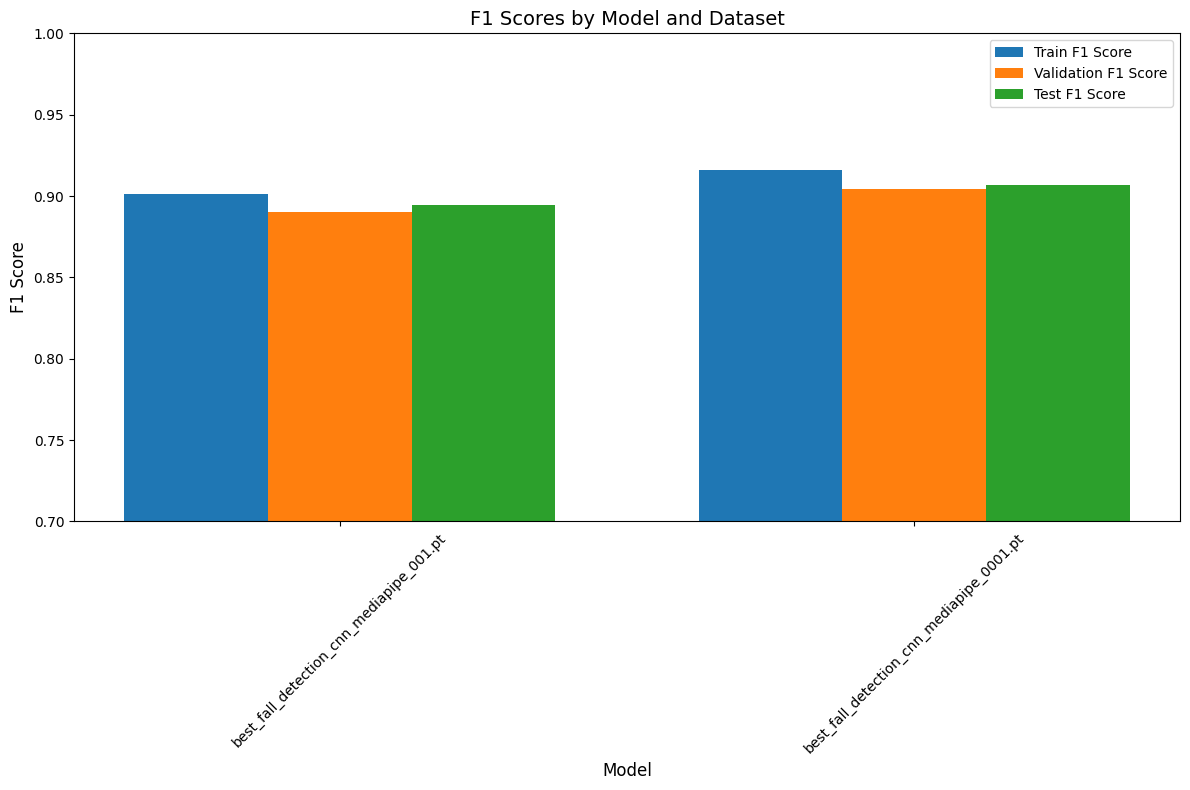

In [26]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in cnn_results]
train_scores = [result['Train'] for result in cnn_results]
val_scores = [result['Validation'] for result in cnn_results]
test_scores = [result['Test'] for result in cnn_results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

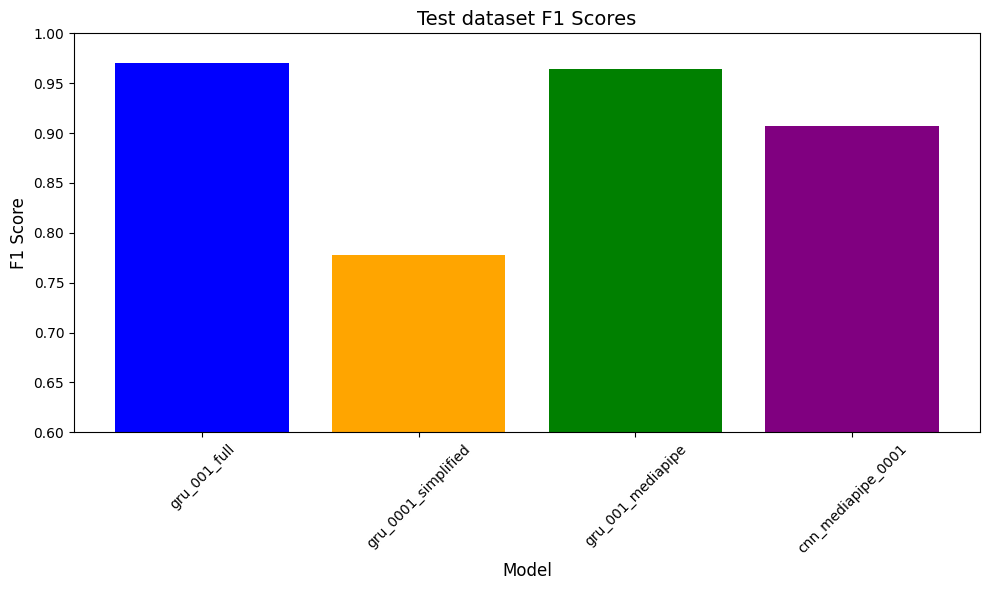

In [27]:
# 선택된 모델들에 대해서만 Test F1 Score 추출
selected_model_names = [
    'best_fall_detection_gru_001_full.pt',
    'best_fall_detection_gru_0001_simplified.pt',
    'best_fall_detection_gru_001_mediapipe.pt',
    'best_fall_detection_cnn_mediapipe_0001.pt'
]

# model_f1_scores 리스트 작성
model_f1_scores = []
for model_name in selected_model_names:
    # gru_results와 cnn_results에서 모델을 찾기
    test_f1_score = None
    for result in gru_results + cnn_results:
        if result['Model'] == model_name:
            test_f1_score = result['Test']
            break
    
    if test_f1_score is not None:
        model_f1_scores.append((model_name, test_f1_score))

# 그래프용 데이터 변환
model_names = [name.split('best_fall_detection_')[1].replace('.pt', '') for name, _ in model_f1_scores]
test_f1_scores = [score for _, score in model_f1_scores]

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(model_names, test_f1_scores, color=['blue', 'orange', 'green', 'purple'])

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Test dataset F1 Scores", fontsize=14)
plt.ylim(0.6, 1.0)

# x축 라벨의 가독성을 위해 회전 추가
plt.xticks(rotation=45, fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()